In [1]:
import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

import itertools

from wrangle import wrangle_hud
import preprocessing as pr


Bad key "text.kerning_factor" on line 4 in
/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Acquire
All functions are called in `wrangle.py` file.
## Functions
- `acquire_fha_data.py` - This function takes fha data from hud website (url, sheet_name) turns it into pandas df.
    - url = https://www.hud.gov/sites/dfiles/Housing/documents/Initi_Endores_Firm%20Comm_DB_FY06_FY20_Q2.xlsx
    - sheet_name = "Firm Cmtmts, Iss'd and Reiss'd"
    - The dataset can be physically found at https://www.hud.gov/program_offices/housing/mfh/mfdata/mfproduction

# Prepare
All functions are called in `wrangle.py` file


## Functions

- `drop_multiple_fha_numbers` - Drops repeat entries by taking the most recent option
- `snake_case_column_names` - makes column names snake case
- `change_to_bool` - changes columns with [0, Y] values to bool (Y= True)
- `changing_data_types` - changes dtypes for datetime and turn fha_number into an object
- `make_activity_construction_bool` - makes boolean columns for is_refinance and is_new_construction
- `wrangle_hud` - mother function that also removes lower outlier and does some minor cell changes

In [3]:
df = wrangle_hud()

## Data Summary

In [4]:
print (f'This data frame is {df.shape[0]} rows and {df.shape[1]} columns.')
print ('Currently, each observation is one mortgage, which will change for modelling')
print()
print()
df.info()

This data frame is 20409 rows and 31 columns.
Currently, each observation is one mortgage, which will change for modelling


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20409 entries, 0 to 20514
Data columns (total 31 columns):
 #   Column                                                                Non-Null Count  Dtype         
---  ------                                                                --------------  -----         
 0   fha_number                                                            20409 non-null  object        
 1   project_name                                                          20409 non-null  object        
 2   project_city                                                          20409 non-null  object        
 3   project_state                                                         20409 non-null  object        
 4   basic_fha_risk_share_or_other                                         20409 non-null  object        
 5   program_category   

In [5]:
df.head(2)

,fha_number,project_name,project_city,project_state,basic_fha_risk_share_or_other,program_category,activity_description,activity_group,facility_type,program_designation,...,tax_exempt_bond_designation,home_designation,cdbg_designation,section_202_refi_designation,irp_decoupling_designation,hope_vi_designation,current_status,final_mortgage_amount,is_refinance,is_new_construction
0,11345004,Western Heights Apartments,Olney,TX,Basic FHA,223a7 Refi Apts,Refinance,Refi/ Pchse,Apts,a7/236,...,False,False,False,False,False,False,Firm Comit then Owner Withdrew,271700,True,False
1,11345005,Woodlands Village Apts,Breckenridge,TX,Basic FHA,223a7 Refi Apts,Refinance,Refi/ Pchse,Apts,a7/236,...,False,False,False,False,False,False,Finally Endorsed,168300,True,False


Text(0.5, 1.0, 'Histogram of Mortgages by Year')

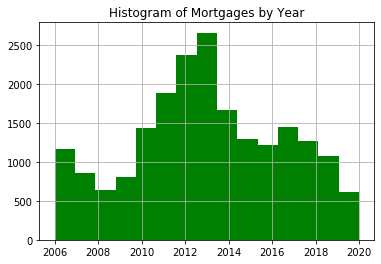

In [6]:
df.fiscal_year_of_firm_commitment_activity.hist(color='green', bins=15)
plt.title('Histogram of Mortgages by Year')

Text(0, 0.5, '')

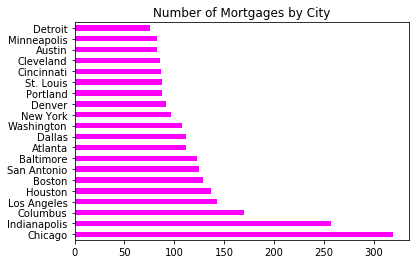

In [7]:
df.groupby('project_city').final_mortgage_amount.count().nlargest(20).plot.barh(color='magenta')
plt.title('Number of Mortgages by City')
plt.ylabel("")

Text(0.5, 1.0, 'Outliers Skewing Mortgage amount Data')

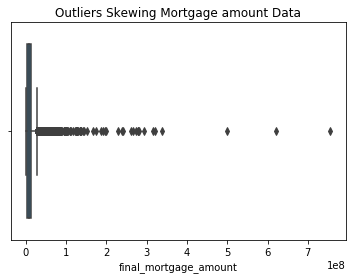

In [8]:
sns.boxplot(df.final_mortgage_amount)
plt.title("Outliers Skewing Mortgage amount Data")

In [9]:
mean_diff = df.final_mortgage_amount.mean()-df.final_mortgage_amount.median()
print(f'The difference between the mean and the median is {round(mean_diff)}')

df.final_mortgage_amount.describe()

The difference between the mean and the median is 4063026


count       20409.00
mean     10785326.03
std      15642874.34
min         70100.00
25%       3420500.00
50%       6722300.00
75%      13295800.00
max     755874500.00
Name: final_mortgage_amount, dtype: float64

# Exploration

# Preprocessing

In order to get our data into a useable format for modeling we decided to group the data by city and state for each fiscal year to get unique observations. Below is a brief summary of the functions found in the `preprocessing.py` script which help to restructure our data into a useable format:

- `get_model_df`: This function wrangles the original data, groups the data using the city, state, and fiscal year features, and aggregates the mortgage data appropriately.
- `calculate_city_state_vol_delta`: This function creates the growth rate for each unique city + state + year observation using total mortgage volume.
- `calculate_city_state_qty_delta`: This function creates the growth rate for each unique city + state + year observation using the quantity of mortgages.
- `calculate_evolution_index`: This function calculates the evolution index using the market volume delta feature created within using the market volume feature. The evolution index is a measure which expresses the growth of a unique city + state + year observation relative to the the overall market growth rate for the whole year.
- `add_new_features`: This function calls `calculate_city_state_vol_delta`, `calculate_city_state_qty_delta`, and `calculate_evolution_index` to add new features to the modeling DataFrame.
- `train_validate_test_data`: This function slipts our data into train, validate, and test for modeling.
- `prep_data_for_modeling`: 

In [10]:
model_df = pr.get_model_df()
print(f"""Our modeling DataFrame contains {model_df.shape[0]:,} observations & {model_df.shape[1]} features""")
model_df.head()

Our modeling DataFrame contains 13,507 observations & 12 features


,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label
0,Bronx,NY,2013,8,822430600,102803825.00,24774500.00,nan,nan,nan,nan,False
1,Trenton,NJ,2009,3,760934400,253644800.00,4100000.00,1.00,755874500.00,755874500.00,755874500.00,False
2,New York,NY,2013,6,616362504,102727084.00,18382352.00,1.00,9364704.00,9364704.00,9364704.00,False
3,Chicago,IL,2012,44,510069300,11592484.09,7710000.00,nan,nan,nan,nan,False
4,Chicago,IL,2011,41,462365300,11277202.44,8677500.00,1.00,5387000.00,5387000.00,5387000.00,False


In [11]:
model_df = pr.add_new_features(model_df)
print(f"""Our modeling DataFrame now contains {model_df.shape[0]:,} observations & {model_df.shape[1]} features""")
model_df.head()

Our modeling DataFrame now contains 13,507 observations & 19 features


,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei
7735,Abbeville,LA,2013,1,6500000,6500000.00,6500000.00,nan,nan,nan,nan,False,nan,nan,nan,nan,24940177380,nan,nan
12512,Abbeville,SC,2008,1,1552900,1552900.00,1552900.00,nan,nan,nan,nan,False,nan,nan,nan,nan,4444102426,-0.82,nan
7500,Aberdeen,MD,2006,2,6828000,3414000.00,3414000.00,nan,nan,nan,nan,False,nan,nan,nan,nan,6774129256,nan,nan
1410,Aberdeen,MD,2013,3,34075100,11358366.67,4639800.00,1.00,27247100.00,27247100.00,27247100.00,False,3.99,nan,0.50,nan,24940177380,2.68,1.36
7710,Aberdeen,MD,2015,1,6525000,6525000.00,6525000.00,nan,nan,nan,nan,False,-0.81,0.00,-0.67,0.00,13569931547,-0.46,0.35
